In [2]:
import prepare
import model

import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt

import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

### Using store_item_sales for modeling

In [3]:
# Read in the data
df = pd.read_csv('joined_df.csv',index_col=0)

In [4]:
# Strip out the time leaving the the year-month-day
df.sale_date = df.sale_date.apply(lambda x: x[:-13])

In [5]:
# Set the index on the sale date
df = prepare.set_index(df, 'sale_date')

In [6]:
# Split the data
train_size = .70
n = df.shape[0]
test_start_index = round(train_size * n)

train = df[:test_start_index] # everything up (not including) to the test_start_index
test = df[test_start_index:] # everything from the test_start_index to the end

In [7]:
train

,sale_amount,sale_id,store_address,store_city,store_id,store_state,store_zipcode,item_brand,item_id,item_name,item_price,item_upc12,item_upc14
sale_date,,,,,,,,,,,,,
2013-01-01,13.0,1,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013
2013-01-01,26.0,211817,12018 Perrin Beitel Rd,San Antonio,7,TX,78217,Mueller,12,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211
2013-01-01,27.0,832657,12018 Perrin Beitel Rd,San Antonio,7,TX,78217,Mama Marys,46,Pizza Sauce,4.65,35457770664,35457770664
2013-01-01,54.0,213643,15000 San Pedro Ave,San Antonio,8,TX,78232,Mueller,12,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211
2013-01-01,35.0,215469,735 SW Military Dr,San Antonio,9,TX,78221,Mueller,12,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-07-02,46.0,877759,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Easy-off,49,Easy-off Oven Cleaner Lemon Scent,9.54,62338879772,62338879772
2016-07-02,39.0,278831,2118 Fredericksburg Rdj,San Antonio,3,TX,78201,Burts Bees,16,Burts Bees Daily Moisturizing Cream Sensitive,5.17,792850014008,792850014008
2016-07-02,58.0,749939,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Moms Best Naturals,42,Moms Best Naturals Cereal Toasted Cinnamon Squ...,2.97,883978129115,883978129115


Text(0, 0.5, 'sale_amount')

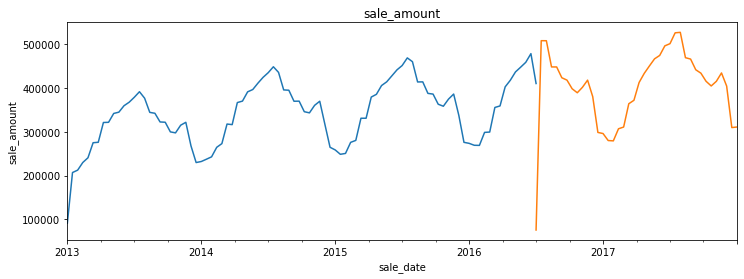

In [8]:
# Plot the sale amount on a biweekly timeframe

plt.figure(figsize=(12,4))
train['sale_amount'].resample('2W').sum().plot()
test['sale_amount'].resample('2W').sum().plot()
plt.title('sale_amount')
plt.ylabel('sale_amount')

Text(0, 0.5, 'item_price')

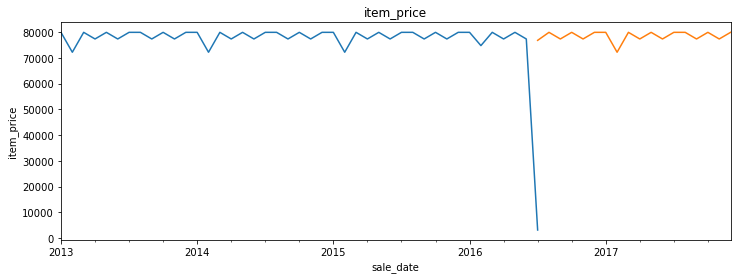

In [9]:
# Plot the item price on a monthly basis

plt.figure(figsize=(12,4))
train['item_price'].resample('M').sum().plot()
test['item_price'].resample('M').sum().plot()
plt.title('item_price')
plt.ylabel('item_price')

In [10]:
# Aggregate the sale date, sale amount and item price
df = df.groupby(['sale_date'])[['sale_amount','item_price']].sum()

In [11]:
df.head()

,sale_amount,item_price
sale_date,,
2013-01-01,13696.0,2580.2
2013-01-02,13678.0,2580.2
2013-01-03,14488.0,2580.2
2013-01-04,15677.0,2580.2
2013-01-05,16237.0,2580.2


In [24]:
def make_predictions():
    yhat_df = pd.DataFrame({'sale_amount': [amount],
                            'item_price': [price],
                           }, index = train.index)
    return yhat_df


In [26]:
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(train[target_var], yhat_df[target_var])), 0)
    return rmse

In [27]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [28]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

### Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
 - Simple Average
 - Moving Average
 - Holt's Linear Trend Model
 - Based on previous year/month/etc., this is up to you.

In [16]:
amount = round(train['sale_amount'].mean(), 2)
price = round(train['item_price'].mean(), 2)

In [20]:
train.columns.to_list()

['sale_amount',
 'sale_id',
 'store_address',
 'store_city',
 'store_id',
 'store_state',
 'store_zipcode',
 'item_brand',
 'item_id',
 'item_name',
 'item_price',
 'item_upc12',
 'item_upc14']

In [21]:
yhat_df = pd.DataFrame({'sale_amount': [amount],
                            'item_price': [price],
                           }, index = train.index)

In [22]:
yhat_df.head()

,sale_amount,item_price
sale_date,,
2013-01-01,49.42,5.16
2013-01-01,49.42,5.16
2013-01-01,49.42,5.16
2013-01-01,49.42,5.16
2013-01-01,49.42,5.16


sale_amount -- RMSE: 27


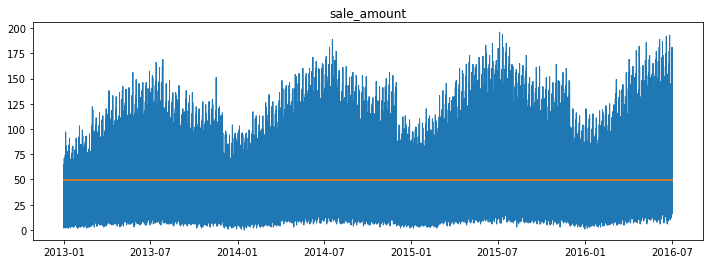

item_price -- RMSE: 3


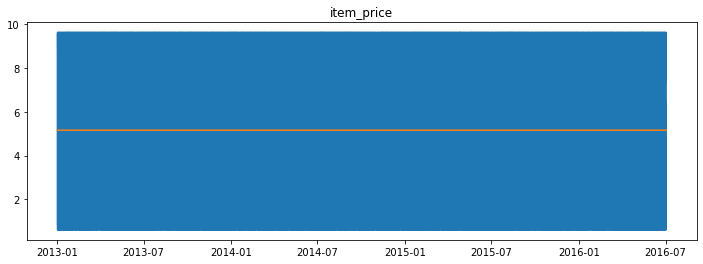

In [29]:
plot_and_eval('sale_amount')
plot_and_eval('item_price')

In [30]:
eval_df = append_eval_df('simple_average', 'sale_amount')
eval_df = append_eval_df('simple_average', 'item_price')

#### Moving Average